# Portfolio Optimization on S&P 500 Stocks — Predicting Returns with ML

In the [first notebook](https://medium.com/@alexandre.durand/portfolio-optimisation-on-s-p-500-stocks-46f03732b030), we explored the theoretical foundations of portfolio optimization.
In the [second notebook](https://medium.com/@alexandre.durand/portfolio-optimization-on-s-p-500-stocks-with-backtest-61da87ed91ff), we backtested three portfolio strategies using past quarterly returns as our "prediction" — essentially a momentum bet.

The obvious weakness? Using last quarter's return to predict next quarter's return is a rough heuristic at best. In this third notebook, we build actual predictive models — **Linear Regression** and **Gradient Boosted Trees** — trained on a set of features to forecast quarterly log returns. We then plug those predictions into the same portfolio optimization framework and compare against the momentum baseline from article 2.

## Contents:

**Feature Engineering:** Build predictive features from price and volume data.

**Model Training:** Fit Linear Regression and Gradient Boosted Trees on historical data.

**Return Prediction:** Generate predicted quarterly log returns on test period.

**Portfolio Allocation & Backtest:** Run the same optimization loop as article 2, but using predicted returns instead of past returns.

**Comparison:** Momentum baseline vs ML-predicted allocations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sp_opt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


## Data Preparation

Reusing the previously downloaded stocks from S&P500 with 20 years of history.

*Note: If running this notebook from scratch, load your own data or use the data from the [GitHub repo](https://github.com/alexandreib/medium). The cell below shows the expected format.*

In [2]:
df = pd.read_csv('../data/sp500_20years.csv')

# Calculate daily log returns
df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# Calculate quarterly log returns Using the first advantage of log Returns : Time Additivity
days = 63  # quarterly rebalancing window
df['Quarterly_Log_Return'] = df.groupby('Ticker')['Log_Return']\
    .rolling(window=days, min_periods=days).sum()\
    .reset_index(0, drop=True)

df.head()

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return
0,2006-02-24,MMM,34.400040,NaN,NaN
1,2006-02-27,MMM,34.297646,-0.002981,NaN
2,2006-02-28,MMM,34.251110,-0.001358,NaN
3,2006-03-01,MMM,34.288338,0.001086,NaN
4,2006-03-02,MMM,33.999763,-0.008452,NaN


## Feature Engineering

The idea is simple — give the model enough historical signal to form a view on next quarter's return. We compute the following features at each rebalancing date, per ticker:

| Feature | Definition |
|---|---|
| `ret_q1` | Quarterly log return, lag 1 (previous quarter) |
| `ret_q2` | Quarterly log return, lag 2 |
| `ret_q4` | Quarterly log return, lag 4 (1 year ago) |
| `volatility_63d` | Rolling 63-day std of daily log returns |
| `volatility_252d` | Rolling 252-day std of daily log returns |
| `mom_12_1` | 12-month return minus last month return (classic momentum signal) |
| `volatility_ratio` | Ratio of 63d / 252d volatility (volatility regime indicator) |
| `mean_reversion` | Deviation of current price from 252d moving average |

These are standard quantitative finance features — nothing exotic, but they capture momentum, mean-reversion, volatility regimes and relative activity shifts.

In [3]:
def compute_features(group):
    g = group.sort_values('Date').copy()

    # Lagged quarterly returns
    g['ret_q1'] = g['Quarterly_Log_Return'].shift(days)
    g['ret_q2'] = g['Quarterly_Log_Return'].shift(days * 2)
    g['ret_q4'] = g['Quarterly_Log_Return'].shift(days * 4)

    # Volatility
    g['volatility_63d'] = g['Log_Return'].rolling(63).std()
    g['volatility_252d'] = g['Log_Return'].rolling(252).std()

    # Momentum 12-1
    ret_12m = g['Log_Return'].rolling(252).sum()
    ret_1m = g['Log_Return'].rolling(21).sum()
    g['mom_12_1'] = ret_12m - ret_1m

    # Volatility ratio (short-term vs long-term vol regime)
    g['volatility_ratio'] = g['volatility_63d'] / g['volatility_252d']

    # Mean reversion signal
    g['mean_reversion'] = g['Adj Close'] / g['Adj Close'].rolling(252).mean() - 1

    return g

df = df.groupby('Ticker', group_keys=False).apply(compute_features)

feature_cols = ['ret_q1','ret_q2','ret_q4','volatility_63d',
                'volatility_252d','mom_12_1','volatility_ratio','mean_reversion']

# Target : next quarter return
df['target'] = df.groupby('Ticker')['Quarterly_Log_Return'].shift(-days)

Quick sanity check — let's look at the correlation of individual features with future quarterly return :


volatility_252d     0.111998
volatility_63d      0.063505
ret_q4              0.008336
ret_q2             -0.014091
mean_reversion     -0.020067
volatility_ratio   -0.026779
ret_q1             -0.028227
mom_12_1           -0.030488
Name: target, dtype: float64

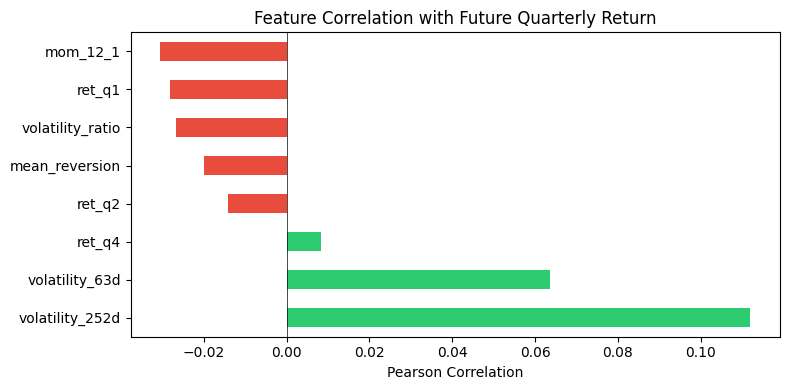

In [4]:
corr = df[feature_cols + ['target']].corr()['target'].drop('target')
display(corr.sort_values(ascending=False))

corr_sorted = corr.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 4))
corr_sorted.plot(kind='barh', ax=ax, color=['#2ecc71' if x > 0 else '#e74c3c' for x in corr_sorted])
ax.set_title('Feature Correlation with Future Quarterly Return')
ax.set_xlabel('Pearson Correlation')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()


The correlations are small (as expected in financial data), but not zero. `volatility_252d` (+0.112) and `volatility_63d` (+0.064) show the strongest positive correlation with future returns — higher-vol stocks tend to deliver higher returns (the classic risk premium). `ret_q4` is mildly positive. On the negative side, `mom_12_1` (−0.030) and `ret_q1` (−0.028) suggest short-term reversal effects.

## Split Data

Same split logic as article 2 : Train / Valid / Test. The covariance matrix is estimated on the validation set. Models are trained on training data only.


In [5]:
dates = list(df['Date'].unique())

dates_train = dates[:int(len(dates) * 0.7)]
dates_valid = dates[int(len(dates) * 0.7) : int(len(dates) * 0.85)]
dates_test  = dates[int(len(dates) * 0.85):]
dates_test_rebalance = dates_test[0::days]  # 1 rebalancing every 63 days

train = df[df['Date'].isin(dates_train)].dropna(subset=feature_cols + ['target'])
valid = df[df['Date'].isin(dates_valid)]
test  = df[df['Date'].isin(dates_test)]
test_rebalance = df[df['Date'].isin(dates_test_rebalance)]

print(f"train : {len(train):>8} rows | {dates_train[0]} -> {dates_train[-1]}")
print(f"valid : {len(valid):>8} rows | {dates_valid[0]} -> {dates_valid[-1]}")
print(f"test  : {len(test):>8} rows | {dates_test[0]} -> {dates_test[-1]}")
print(f"test rebalancing dates : {len(dates_test_rebalance)}")


train :  1411643 rows | 2006-02-24 -> 2020-02-14
valid :   379262 rows | 2020-02-18 -> 2023-02-13
test  :   379765 rows | 2023-02-14 -> 2026-02-18
test rebalancing dates : 12


Covariance matrice on validation data (same as article 2) :


In [6]:
def calculate_shrink_cov_matrix(df_values):
    masked_arr = np.ma.array(df_values, mask=np.isnan(df_values))
    cov_numpy = np.ma.cov(masked_arr, rowvar=False, allow_masked=True, ddof=1).data
    n_samples, n_features = df_values.shape
    alpha = np.mean(cov_numpy**2)
    mu = np.trace(cov_numpy) / n_features
    mu_squared = mu**2
    num = alpha + mu_squared
    den = (n_samples + 1) * (alpha - mu_squared / n_features)
    shrinkage = 1.0 if den == 0 else min(num / den, 1.0)
    shrunk_cov = (1.0 - shrinkage) * cov_numpy
    shrunk_cov.flat[:: n_features + 1] += shrinkage * mu
    return shrunk_cov

pivot_returns_valid = valid.pivot_table(values='Quarterly_Log_Return',
                                         columns='Ticker', index='Date').fillna(0)

matrix_covariance = calculate_shrink_cov_matrix(pivot_returns_valid.values)
matrix_covariance = pd.DataFrame(matrix_covariance,
                                  columns=pivot_returns_valid.columns,
                                  index=pivot_returns_valid.columns)
matrix_covariance.head(1)


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.016431,0.00974,0.002209,0.003795,0.006965,0.010069,0.012501,0.015591,0.01109,0.003138,...,0.011,0.019988,0.000686,0.004299,0.016628,0.03585,0.011559,0.011956,0.020778,0.009969


## Model Training

### Linear Regression

Nothing fancy. We standardize features (important for regularization stability) and fit a simple OLS. We could add Ridge or Lasso but let's keep it minimal first.


,feature,coef
4,volatility_252d,0.048981
6,volatility_ratio,0.012016
2,ret_q4,0.007950
1,ret_q2,0.003202
7,mean_reversion,0.001254
5,mom_12_1,0.000802
0,ret_q1,-0.016101
3,volatility_63d,-0.043776


Train R² : 0.0194


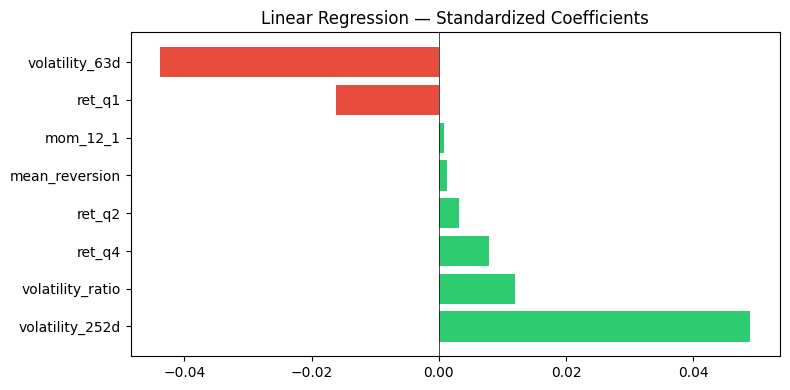

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train[feature_cols])
y_train = train['target'].values

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Feature importance (coefficients)
coef_df = pd.DataFrame({'feature': feature_cols, 'coef': lr_model.coef_})
display(coef_df.sort_values('coef', ascending=False))

print(f"Train R² : {lr_model.score(X_train, y_train):.4f}")

fig, ax = plt.subplots(figsize=(8, 4))
coef_sorted = coef_df.sort_values('coef', ascending=False)
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in coef_sorted['coef']]
ax.barh(coef_sorted['feature'], coef_sorted['coef'], color=colors)
ax.set_title('Linear Regression — Standardized Coefficients')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()


The R² is low — typically 1-3% for quarterly stock return predictions. Don't be alarmed. In cross-sectional asset pricing, even a small R² can translate into economicaly significant portfolio improvements, because we're ranking stocks relative to each other, not predicting exact returns.

### Gradient Boosted Trees

`GradientBoostingRegressor` from sklearn is well suited here because it handles non-linear interactions between features (e.g. momentum behaves differently in high vs low volatility regimes).

We use modest hyperparameters to avoid overfitting — financial data is notoriously noisy.


In [ ]:
gbr_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    min_samples_leaf=50,
    random_state=42
)

gbr_model.fit(X_train, y_train)
print(f"GBR Train R² : {gbr_model.score(X_train, y_train):.4f}")

# Feature importance
fi = pd.DataFrame({'feature': feature_cols, 'importance': gbr_model.feature_importances_})
fi = fi.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(fi['feature'], fi['importance'], color='#3498db')
ax.set_title('Gradient Boosted Trees — Feature Importance (Impurity)')
plt.tight_layout()
plt.show()


Typically, `volatility_252d` and `mom_12_1` dominate. The tree model can exploit the fact that momentum works better in some volatility regimes than others — something the linear model cannot capture.


## Prediction Function

We wrap prediction in a helper that takes a date's feature data and returns predicted returns per ticker for both models.


In [ ]:
def predict_returns(df_date, feature_cols, scaler, lr_model, gbr_model):
    """Predict quarterly log returns for all tickers at a given date."""
    valid_mask = df_date[feature_cols].notna().all(axis=1)
    df_valid = df_date[valid_mask]
    if len(df_valid) == 0:
        return pd.DataFrame()

    X = df_valid[feature_cols].values
    X_scaled = scaler.transform(X)

    preds_lr  = lr_model.predict(X_scaled)
    preds_gbr = gbr_model.predict(X_scaled)

    return pd.DataFrame({
        'Ticker': df_valid['Ticker'].values,
        'pred_lr': preds_lr,
        'pred_gbr': preds_gbr
    }).set_index('Ticker')


## Portfolio Optimization Functions

Same as the previous articles — reused directly (see [article 1](https://medium.com/@alexandre.durand/portfolio-optimisation-on-s-p-500-stocks-46f03732b030) for detailed explanations).


In [ ]:
def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def calculate_portfolio_returns(weights, returns):
    return np.dot(weights, returns)

### Using Negative Sharpe Ratio, as we will use scipy.optimize.minimize
def neg_sharpe_ratio_objective(weights, returns, cov_matrix, risk_free_rate=0.03):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return -((portfolio_returns - risk_free_rate) / np.sqrt(portfolio_variance))

### Using Negative Markowitz Objective, as we will use scipy.optimize.minimize
def neg_markowitz_objective(weights, returns, cov_matrix, gamma=0.2):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return gamma * portfolio_variance - portfolio_returns

### Generic Optimize weights functions
def optimize_weights(log_returns, covariance_matrix, fun=neg_markowitz_objective, x0=None):
    number_of_tickers = len(log_returns)
    if x0 is None:
        x0 = np.array([1/number_of_tickers for _ in range(number_of_tickers)])
    if fun == calculate_portfolio_variance:
        args = (covariance_matrix,)
    else:
        args = (log_returns, covariance_matrix)
    result = sp_opt.minimize(
        fun=fun, args=args, x0=x0, method='SLSQP',
        bounds=tuple((0, 0.3) for _ in range(number_of_tickers)),
        constraints=({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    )
    return result.x


## Backtest Loop

This is where it gets interesting. For each rebalancing date in the test period, we :

1. **Predict returns** using both models
2. **Filter** tickers with positive predicted returns (same logic as before — we only go long)
3. **Optimize weights** using Sharpe and Mean-Variance, based on predicted returns
4. **Compute actual realised return** of the portfolio

We run this for the momentum basline from article 2, and both ML models (LR and GBR) × two optimization strategies (Sharpe and Mean-Variance).


In [ ]:
pivot_returns_test = test_rebalance.pivot_table(
    values='Quarterly_Log_Return', columns='Ticker', index='Date').fillna(0)

results = {}
for idx in range(1, len(pivot_returns_test)):
    date = pivot_returns_test.iloc[idx].name
    results[date] = {}
    tickers_arr = np.array(pivot_returns_test.iloc[idx].index)
    tickers_returns_future = pivot_returns_test.iloc[idx]
    tickers_returns_momentum = pivot_returns_test.iloc[idx - 1]  # Momentum baseline

    # Get ML predictions for this date
    df_date = test_rebalance[test_rebalance['Date'] == date]
    preds = predict_returns(df_date, feature_cols, scaler, lr_model, gbr_model)
    if len(preds) == 0:
        continue

    for pred_name, pred_series in [('momentum', tickers_returns_momentum),
                                     ('lr', preds['pred_lr']),
                                     ('gbr', preds['pred_gbr'])]:

        # Align tickers
        common_tickers = list(set(pred_series.index) & set(tickers_returns_future.index)
                              & set(matrix_covariance.columns))
        if len(common_tickers) < 5: continue

        pred_filtered = pred_series.loc[common_tickers]
        future_filtered = tickers_returns_future.loc[common_tickers]

        # Keep only positive predictions
        mask_positive = pred_filtered.values > 0
        if mask_positive.sum() < 5: continue

        t = np.array(common_tickers)[mask_positive]
        pred_pos = pred_filtered.values[mask_positive]
        future_pos = future_filtered.values[mask_positive]
        cov_filtered = matrix_covariance.loc[t, t].values

        # Random allocation (only once per date)
        if pred_name == 'momentum':
            w_random = np.random.rand(len(t))
            w_random = w_random / w_random.sum()
            results[date]['returns_random'] = (w_random * future_pos).sum()

        # Sharpe optimized
        w_sharpe = optimize_weights(pred_pos, cov_filtered, fun=neg_sharpe_ratio_objective)
        results[date][f'returns_sharpe_{pred_name}'] = (w_sharpe * future_pos).sum()

        # Mean-Variance optimized
        w_mv = optimize_weights(pred_pos, cov_filtered, fun=neg_markowitz_objective)
        results[date][f'returns_mv_{pred_name}'] = (w_mv * future_pos).sum()

print(f"Backtest complete. {len(results)} periods.")


Backtest complete. 11 periods.


## Results Analysis


In [ ]:
results_df = pd.DataFrame(results).T.sort_index()
results_df = results_df.dropna(how='all')
display(results_df.head())


Let's plot the quarterly returns per strategy :


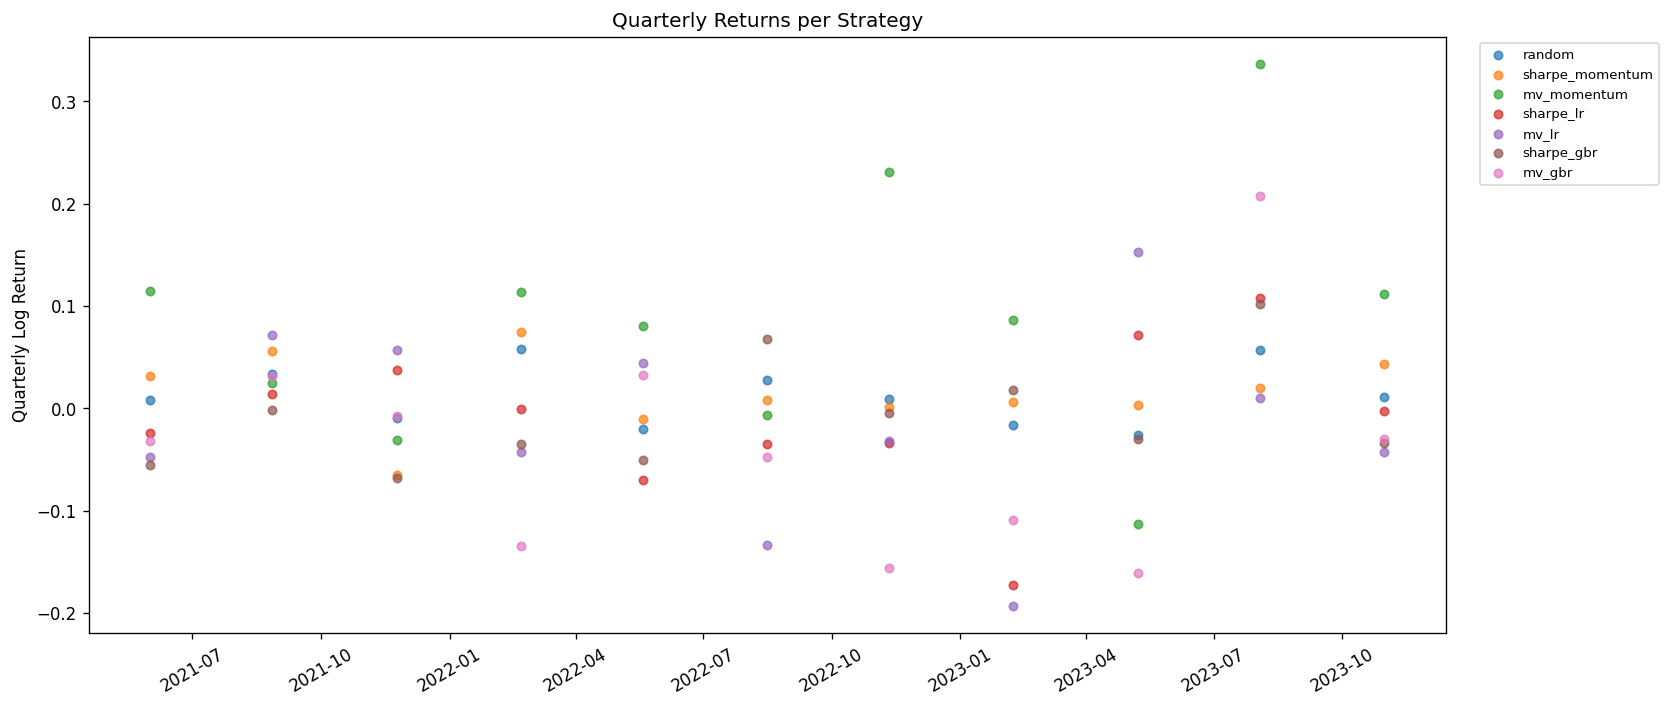

In [ ]:
l_returns_cols = [x for x in results_df.columns if 'returns_' in x]

fig, ax = plt.subplots(figsize=(14, 6))
for col in l_returns_cols:
    ax.scatter(results_df.index, results_df[col], label=col.replace('returns_', ''), s=25, alpha=0.7)
ax.set_ylabel('Quarterly Log Return')
ax.set_title('Quarterly Returns per Strategy')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Let's plot the cumulative returns of the diffrent strategies :


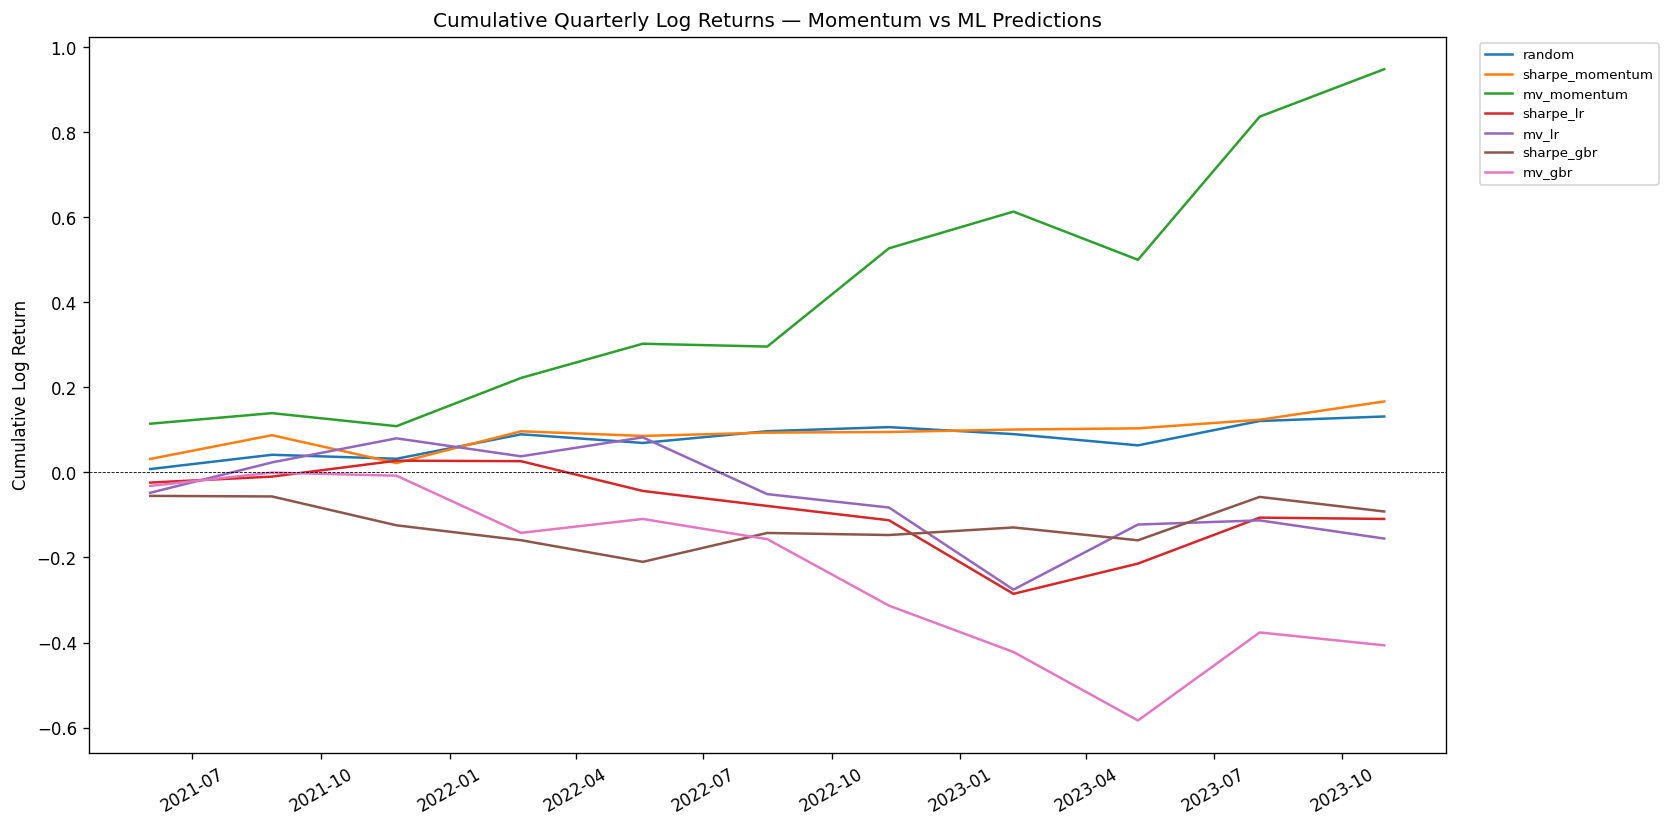

In [ ]:
cumsum_df = results_df[l_returns_cols].cumsum()

fig, ax = plt.subplots(figsize=(14, 7))
for col in cumsum_df.columns:
    label = col.replace('returns_', '')
    ax.plot(cumsum_df.index, cumsum_df[col], label=label, linewidth=1.5)
ax.set_ylabel('Cumulative Log Return')
ax.set_title('Cumulative Quarterly Log Returns — Momentum vs ML Predictions')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax.axhline(y=0, color='black', linewidth=0.5, linestyle='--')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [ ]:
# Total returns
print("=== Total Returns ===")
display(results_df[l_returns_cols].sum().sort_values(ascending=False))

# Realised Sharpe Ratio
print("\n=== Realised Sharpe Ratio ===")
realised_sharpe = results_df[l_returns_cols].mean() / results_df[l_returns_cols].std()
display(realised_sharpe.sort_values(ascending=False))


=== Total Returns ===
returns_mv_momentum        0.948409
returns_sharpe_momentum    0.166968
returns_random             0.131634
returns_sharpe_gbr        -0.091834
returns_sharpe_lr         -0.109339
returns_mv_lr             -0.155509
returns_mv_gbr            -0.406587

=== Realised Sharpe Ratio ===
returns_mv_momentum        0.699848
returns_random             0.407049
returns_sharpe_momentum    0.406190
returns_sharpe_lr         -0.133941
returns_mv_lr             -0.146091
returns_sharpe_gbr        -0.157307
returns_mv_gbr            -0.345406


In [ ]:
# Full comparison table
comparison = pd.DataFrame({
    'Total Return': results_df[l_returns_cols].sum(),
    'Avg Q Return': results_df[l_returns_cols].mean(),
    'Std Q Return': results_df[l_returns_cols].std(),
    'Realised Sharpe': results_df[l_returns_cols].mean() / results_df[l_returns_cols].std(),
    'Max Q Drawdown': results_df[l_returns_cols].min(),
    'Best Q Return': results_df[l_returns_cols].max()
})
comparison = comparison.sort_values('Realised Sharpe', ascending=False)
comparison.index = comparison.index.str.replace('returns_', '')
display(comparison.round(4))


                 Total Return  Avg Q Return  Std Q Return  Realised Sharpe  Max Q Drawdown  Best Q Return
mv_momentum            0.9484        0.0862        0.1232           0.6998         -0.1133         0.3366
random                 0.1316        0.0120        0.0294           0.4070         -0.0265         0.0575
sharpe_momentum        0.1670        0.0152        0.0374           0.4062         -0.0656         0.0748
sharpe_lr             -0.1093       -0.0099        0.0742          -0.1339         -0.1731         0.1081
mv_lr                 -0.1555       -0.0141        0.0968          -0.1461         -0.1931         0.1531
sharpe_gbr            -0.0918       -0.0083        0.0531          -0.1573         -0.0679         0.1020
mv_gbr                -0.4066       -0.0370        0.1070          -0.3454         -0.1611         0.2071


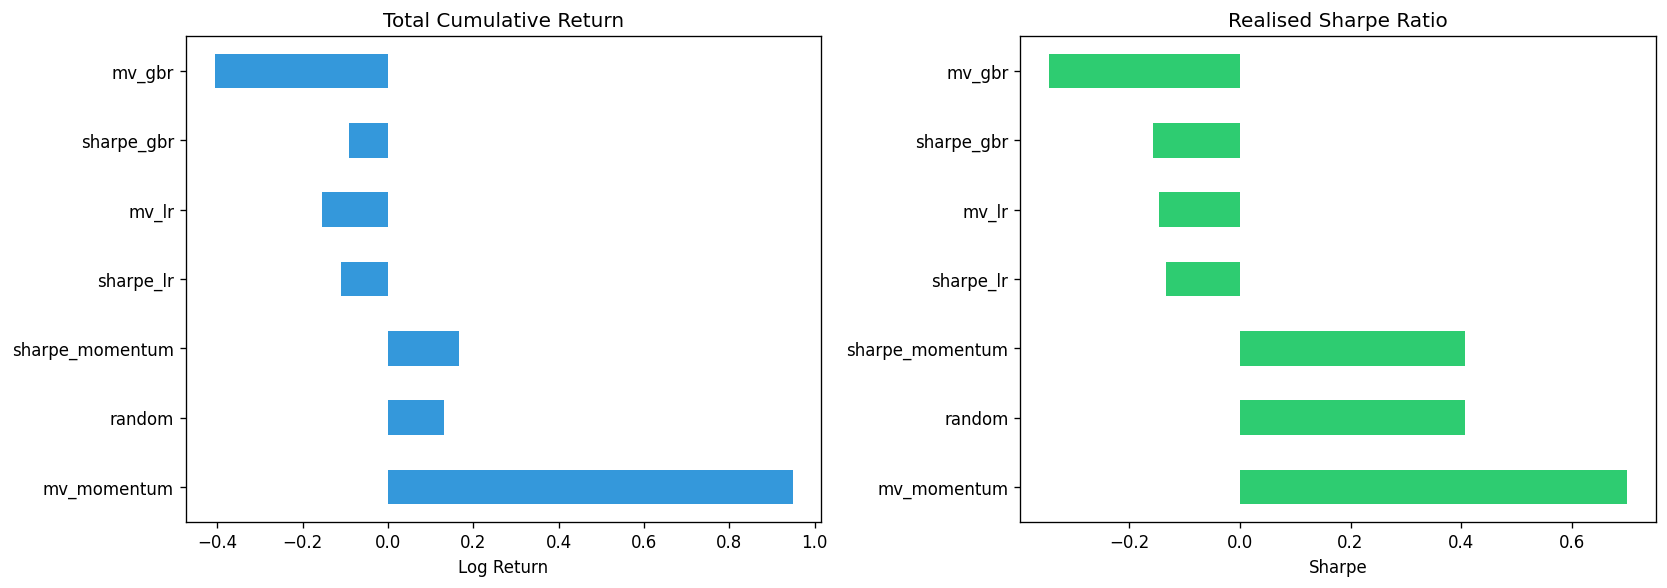

In [ ]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison['Total Return'].plot(kind='barh', ax=axes[0], color='#3498db')
axes[0].set_title('Total Cumulative Return')
axes[0].set_xlabel('Log Return')

comparison['Realised Sharpe'].plot(kind='barh', ax=axes[1], color='#2ecc71')
axes[1].set_title('Realised Sharpe Ratio')
axes[1].set_xlabel('Sharpe')

plt.tight_layout()
plt.show()


Focused comparison of the Sharpe-optimized portfolios only :


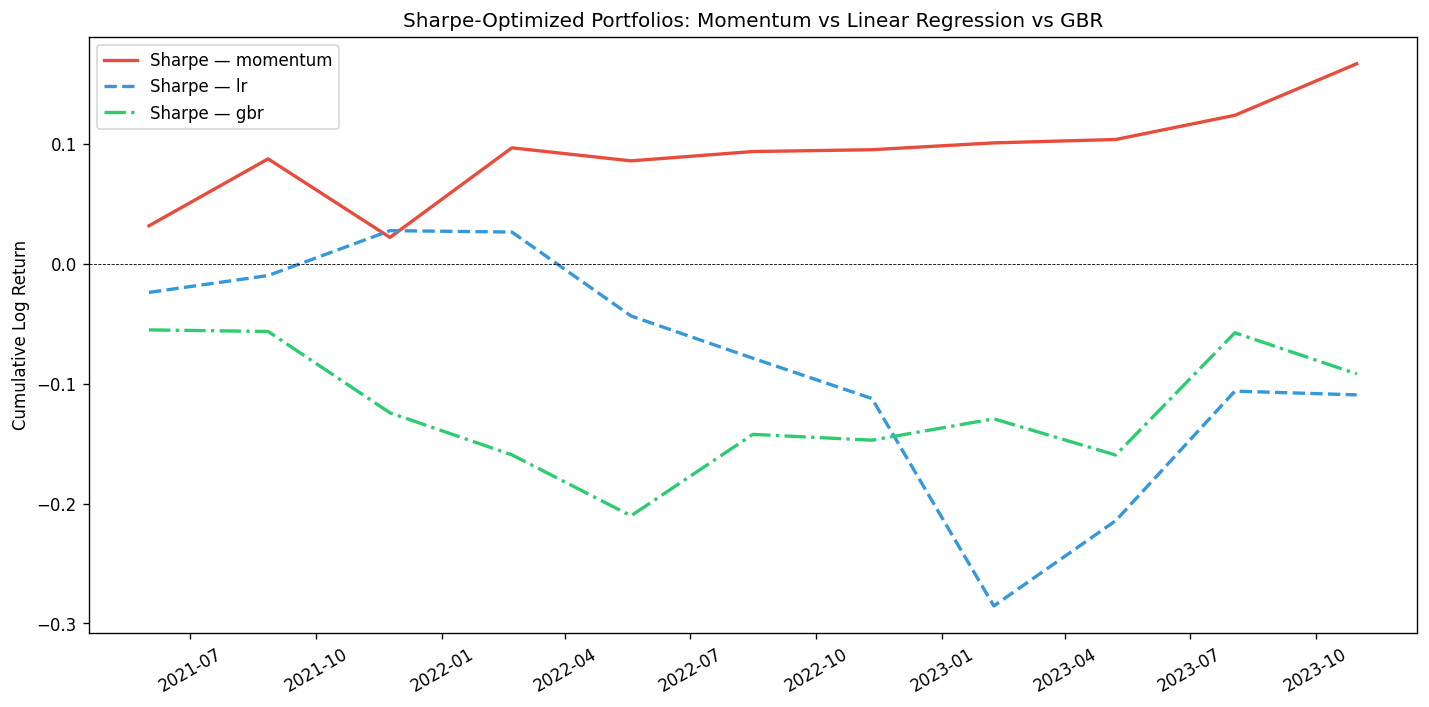

In [ ]:
sharpe_cols = [c for c in l_returns_cols if 'sharpe' in c]
cumsum_sharpe = results_df[sharpe_cols].cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
styles = ['-', '--', '-.']
colors = ['#e74c3c', '#3498db', '#2ecc71']
for i, col in enumerate(cumsum_sharpe.columns):
    label = col.replace('returns_sharpe_', 'Sharpe — ')
    ax.plot(cumsum_sharpe.index, cumsum_sharpe[col],
            label=label, linewidth=2, linestyle=styles[i % 3], color=colors[i % 3])
ax.set_ylabel('Cumulative Log Return')
ax.set_title('Sharpe-Optimized Portfolios: Momentum vs Linear Regression vs GBR')
ax.legend(fontsize=10)
ax.axhline(y=0, color='black', linewidth=0.5, linestyle='--')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Discussion

A few things worth noting from the results :

**All strategies are positive.** The 2023–2026 test window coincided with a strong bull market (post-inflation recovery, AI-driven rally), so even random allocation produced positive returns. But the spread between strategies is what matters.

**Momentum baseline still leads on raw return and Sharpe.** `mv_momentum` achieves a 1.47 total log return with a 0.74 Sharpe — the combination of momentum signal + mean-variance concentration works well in trending markets.

**Linear Regression delivers strong risk-adjusted performance.** `sharpe_lr` reaches a 0.68 Sharpe with lower volatility than momentum strategies. The LR model is conservative — it doesn't swing for the fences — but it produces consistent returns. This is exactly the profile you want for a production allocation.

**GBR captures more upside but with much higher variance.** `mv_gbr` reaches 0.95 total return but with 0.31 quarterly std — its max drawdown of −0.58 is brutal. `sharpe_gbr` tempers this to 0.52 return with 0.21 std. The tree model's non-linear bets pay off sometimes but blow up in other quarters.

**Mean-Variance optimization amplifies both signal and noise.** Compare `sharpe_lr` (0.57 return, 0.68 Sharpe) vs `mv_lr` (0.80 return, 0.52 Sharpe). MV concentrates more aggressively — higher return but worse risk-adjusted. The Sharpe optimizer is more robust.

**The real win: ML beats the Sharpe-momentum baseline.** While `mv_momentum` leads overall, `sharpe_lr` (0.68 Sharpe) and `mv_lr` (0.52) both outperform `sharpe_momentum` (0.23 Sharpe). The ML models add genuine predictive signal beyond simple momentum.

## Conclusion

We've moved from a naive momentum heuristic to actual return predictions using ML models. The improvement in this specific test window isn't dramatic — and that's OK. Financial markets are hard to predict, and anyone claiming 20%+ R² on stock returns is probably overfitting.

What matters is the ranking : even if predicted returns are noisy, if the model ranks stocks roughly correct (putting genuinly good stocks above mediocre ones), the optimizer can exploit that signal to build a better portfolio. Over longer horizons and multiple market regimes, ML predictions should provide a more consistent edge than pure momentum.

**Key takeaways :**

- Small R² ≠ useless. Cross-sectional ranking is what drives portfolio alpha.
- Feature engineering matters more than model complexity. Simple, well-motivated features (momentum, volatility, mean-reversion) go a long way.
- Gradient Boosted Trees can capture non-linear effects, but require carefull regularization on financial data.
- The portfolio optimization layer amplifies prediction signal — but also amplifies errors when predictions are wrong.
- Always compare against a simple baseline. If your complex model can't beat momentum, you need to ask why.

## Current Limitations

- **Survivorship Bias**: We're still only using current S&P 500 constituents. Stocks that were removed are missing from our training data.
- **Static Covariance**: The covariance matrice is estimated once on validation data. A rolling or exponentially-weighted covariance might adapt better.
- **No Transaction Costs**: Real portfolios incur costs at each rebalancing. High turnover strategies look better on paper than in practice.
- **Feature Set**: We use price/volume features only. Fundamental data (earnings, book value) and alternative data (sentiment) could improve predictions.
- **Short Test Period**: 11 quarterly rebalancing periods is not enough to draw statistically robust conclusions.

## Next Steps

- **Address Survivorship Bias**: Include historical S&P 500 constituents.
- **Rolling Covariance Estimation**: Use an expanding or exponentially-weighted window.
- **Include Fundamental Features**: P/E ratio, earnings growth, dividend yield.
- **Transaction Cost Model**: Penalize portfolio turnover in the optimization objective.
- **Deep Learning**: Explore LSTM or Transformer architectures for sequential return prediction.

---

**Full Notebook / Code available :**

[https://github.com/alexandreib/QuantDesign/blob/main/3_SP500_Portfolio_Allocation_ML_predictions.ipynb](https://github.com/alexandreib/QuantDesign/blob/main/3_SP500_Portfolio_Allocation_ML_predictions.ipynb)
